# Radiocarbon with OCIM1

## Setup the Radiocarbon model

We will use the same model of the radiocarbon that is in the trcaer-transport-operator example.

Radiocarbon, ¹⁴C, is produced by cosmic rays in the lower stratosphere and upper troposphere.
It quickly reacts with oxygen to produce ¹⁴CO₂, which is then mixed throughout the troposphere and enters the ocean through air–sea gas exchange.
Because the halflife of radiocarbon is only 5730 years a significant amount of decay can occur before the dissolved inorganic radiocarbon (DI¹⁴C) can mix uniformally throughout the ocean.
As such the ¹⁴C serves as a tracer label for water that was recently in contact with the atmosphere.

### Tracer Equation

Mathematically, the ¹⁴C tracer concentration, denoted $R$ (for Radiocarbon), satisfies the following tracer equation:

$$\frac{\partial R}{\partial t} + \nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \cdot \nabla \right] R = \Lambda(R_\mathsf{atm} - R) - R / \tau,$$

where $\Lambda(R_\mathsf{atm} - R)$ represents the air–sea exchanges and $R / \tau$ the radioactive decay rate.
($\tau$ is the radioactive decay timescale.)

The discretized tracer is thus given by

$$\frac{\partial \boldsymbol{R}}{\partial t} + \mathbf{T} \, \boldsymbol{R} = \mathbf{\Lambda}(R_\mathsf{atm} - \boldsymbol{R}) - \boldsymbol{R} / \tau.$$

### Translation to AIBECS Code

We will perform an idealized radiocarbon simulation in our model and use the ocean circulation defined earlier using AIBECS.
In this model we prescribe the atmospheric concentration, $R_\mathsf{atm}$, to be simply equal to 1.
(We do not specify its unit or its specific value because it is not important for determining the age of a water parcel — only the decay rate does.)

To use AIBECS, one must put the equations into the generic form of

$$\frac{\partial \boldsymbol{x}}{\partial t} + \mathbf{T}(\boldsymbol{p}) \, \boldsymbol{x} = \boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}),$$

where $\boldsymbol{x}$ is the state vector, $\boldsymbol{p}$ is the vector of model parameters, $\mathbf{T}(\boldsymbol{p})$ is the transport operator, and $\boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p})$ is the local sources minus sinks.

In our radiocarbon-model context, with $\boldsymbol{x} = \boldsymbol{R}$, we have that

$$\boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}) = \mathbf{\Lambda}(R_\mathsf{atm} - \boldsymbol{x}) - \boldsymbol{x} / \tau.$$

Hence, we must create `T(p)` and `G(x,p)` to give AIBECS the means to simulate the tracer distribution and/or its evolution in time.

Like for any models using AIBECS, we start by telling Julia just that:

In [1]:
using AIBECS

We then load the OCIM1 model (the grid and the transport) via

In [2]:
wet3D, grd, T = OCIM1.load() ;

Loading OCIM1┌ Warning: Over-writing registration of the datadep
│   name = AIBECS_OCIM1
└ @ DataDeps /home/travis/.julia/packages/DataDeps/RYAia/src/registration.jl:8
 ✔
┌ Info: You are about to use OCIM1 model.
│ If you use it for research, please cite:
│ 
│ - DeVries, T., 2014: The oceanic anthropogenic CO2 sink: Storage, air‐sea fluxes, and transports over the industrial era, Global Biogeochem. Cycles, 28, 631–647, doi:10.1002/2013GB004739.
│ - DeVries, T. and F. Primeau, 2011: Dynamically and Observationally Constrained Estimates of Water-Mass Distributions and Ages in the Global Ocean. J. Phys. Oceanogr., 41, 2381–2401, doi:10.1175/JPO-D-10-05011.1
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "DeVries_Primeau_2011" and "DeVries_2014" keys.)
└ @ AIBECS.OCIM1 /home/travis/build/briochemc/AIBECS.jl/src/OCIM1.jl:53


#### Sources and Sinks

The local sources and sinks are thus simply given by

In [3]:
function G(x, p)
    τ, Ratm = p.τ, p.Ratm
    return Λ(Ratm .- x, p) - x / τ
end

G (generic function with 1 method)

where `τ` is the decay rate timescale and `Ratm` is the atmospheric concentration of radiocarbon.

We must define the air–sea exchange rate, `Λ(x,p)`, which requires us to define which boxes are located at the surface first.
This is done, e.g., via

In [4]:
iwet = findall(vec(wet3D))
surface_boxes = grd.depth_3D[iwet] .== grd.depth[1]

200160-element BitArray{1}:
  true
  true
  true
  true
  true
  true
  true
  true
  true
  true
     ⋮
 false
 false
 false
 false
 false
 false
 false
 false
 false

The air–sea exchange rate is then given by

In [5]:
function Λ(x, p)
    λ, h = p.λ, p.h
    return λ / h * surface_boxes .* x
end

Λ (generic function with 1 method)

where `λ` is the piston velocity and `h` is the height of the top layer of the model grid.

#### Parameters

For the air–sea gas exchange, we use a constant piston velocity $\lambda$ of 50m / 10years, which will happen in the top layer, of height given by, well, the height of the top layer.
And for the radioactive decay we use a timescale $\tau$ of 5730/log(2) years.
We define these as parameters using the dedicated API from the AIBECS:

In [6]:
t = empty_parameter_table()                   # initialize an empty table of parameters
add_parameter!(t, :τ, 5730u"yr"/log(2)) # radioactive decay e-folding timescale
add_parameter!(t, :λ, 50u"m" / 10u"yr") # piston velocity
add_parameter!(t, :h, grd.δdepth[1])    # height of top layer
add_parameter!(t, :Ratm, 1.0u"mol/m^3") # atmospheric concentration
t

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = #add_parameter!#68(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::DataFrames.DataFrame, ::Symbol, ::Vararg{Any,N} where N) at Parameters.jl:64
└ @ AIBECS /home/travis/build/briochemc/AIBECS.jl/src/Parameters.jl:64


,symbol,value,unit,printunit,mean_obs,variance_obs,optimizable,description
,Symbol,Float64,Unitful…,Unitful…,Float64,Float64,Bool,String
1,τ,2.60875e11,s,yr,NaN,NaN,false,
2,λ,1.5844e-7,m s^-1,m yr^-1,NaN,NaN,false,
3,h,36.1351,m,m,NaN,NaN,false,
4,Ratm,1.0,mol m^-3,mol m^-3,NaN,NaN,false,


shows the parameters that you just created.

We now generate a new object to contain all these parameters via

In [7]:
initialize_Parameters_type(t, "C14_OCIM_parameters") # creates the type for parameters
p = C14_OCIM_parameters()                            # creates the parameters object

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = initialize_Parameters_type(::DataFrames.DataFrame, ::String) at Parameters.jl:128
└ @ AIBECS /home/travis/build/briochemc/AIBECS.jl/src/Parameters.jl:128
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = initialize_Parameters_type(::DataFrames.DataFrame, ::String) at Parameters.jl:129
└ @ AIBECS /home/travis/build/briochemc/AIBECS.jl/src/Parameters.jl:129
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = initialize_Parameters_type(::DataFrames.DataFrame, ::String) at Parameters.jl:137
└ @ AIBECS /home/travis/build/briochemc/AIBECS.jl/src/Parameters.jl:137
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = initialize_Parameters_type(::DataFrames.DataFrame, ::String) at Parame

     τ = 8.27e+03 [yr] (fixed)
     λ = 5.00e+00 [m yr⁻¹] (fixed)
     h = 3.61e+01 [m] (fixed)
  Ratm = 1.00e+00 [mol m⁻³] (fixed)


#### Generate the state function and its Jacobian

The last step for the setup is for AIBECS to create $\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = \boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}) - \mathbf{T}(\boldsymbol{p}) \, \boldsymbol{x}$, which defines the rate of change of the state, $\boldsymbol{x}$.
This is done via

In [8]:
F, ∇ₓF = state_function_and_Jacobian(p -> T, G) # generates the state function (and its Jacobian!)
nb = length(iwet)
x = zeros(nb)
F(x,p)

200160-element Array{Float64,1}:
 4.384666933397701e-9
 4.384666933397701e-9
 4.384666933397701e-9
 4.384666933397701e-9
 4.384666933397701e-9
 4.384666933397701e-9
 4.384666933397701e-9
 4.384666933397701e-9
 4.384666933397701e-9
 4.384666933397701e-9
 ⋮                   
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 

> **Note**
> Here, AIBECS has automatically created `∇ₓF`, i.e., $\nabla_{\boldsymbol{x}}\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p})$, which is the Jacobian of the system.
> This Jacobian will be useful in the simulations below.

That's it!
Your model is entirely setup and ready to be used for simulations!

## Run the Radiocarbon model

### Compute the steady-state

Because this model, embedded in the OCIM1 circulation, is much bigger than when embedded in the 5-box shoebox model, it would take quite some computational resournces (in time) to implicitly time-step.
Instead, we will directly solve for the steady-state.
For that, we simply define the steady-state problem and solve it via

In [9]:
prob = SteadyStateProblem(F, ∇ₓF, x, p) # define the problem
R = solve(prob, CTKAlg()).u             # solve the problem

200160-element Array{Float64,1}:
 0.8478189858315391
 0.8465728375268151
 0.8446297170768104
 0.8459424338382593
 0.8543892615069338
 0.8568358393750305
 0.8540349775786992
 0.8557121913324803
 0.859945718705414 
 0.8659179294122077
 ⋮                 
 0.8738687714080563
 0.8746058484789121
 0.8729338479571611
 0.8733838611361412
 0.8741510147599973
 0.8756697132211594
 0.8734898825503115
 0.8739149152305312
 0.8744451299567982

This should take a few seconds on a laptop.
Once the radiocarbon concentration is computed, we can convert it into the corresponding age, via

In [10]:
C14age = -log.(R) * p.τ * u"s" .|> u"yr"

200160-element Array{Quantity{Float64,𝐓,Unitful.FreeUnits{(yr,),𝐓,nothing}},1}:
 1364.7245332175062 yr
 1376.8840164698406 yr
 1395.8800725992671 yr
 1383.0420964662455 yr
 1300.9081458763944 yr
 1277.2701118614953 yr
 1304.3367306307596 yr
  1288.118038955738 yr
 1247.3207115977616 yr
 1190.1083953556883 yr
                     ⋮
 1114.5505967287472 yr
 1107.5809181375062 yr
 1123.3995401234165 yr
  1119.139034521459 yr
 1111.8810560850675 yr
 1097.5315397908048 yr
 1118.1355949294784 yr
 1114.1140959296176 yr
 1109.1001449629232 yr

### Plot the radiocarbon age

First, we must rearrange the age from its column vector shape into the corresponding 3D field.
We start by filling a 3D array of the same size as the grid with some `NaN`s.
(It serves as a blank canvas that we will "color" in with our computed age.)

In [11]:
C14age_3D = fill(NaN, size(grd))     # creates a 3D array of NaNs

91×180×24 Array{Float64,3}:
[:, :, 1] =
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
   ⋮                        ⋮            ⋱              ⋮                    
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN

We use the indices of wet boxes, `iwet`, to fill in the 3D array, via

In [12]:
C14age_3D[iwet] .= ustrip.(C14age)   # Fills the wet grid boxes with the age values

200160-element view(::Array{Float64,1}, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19  …  390449, 390450, 390451, 390539, 390540, 390541, 390542, 390630, 390631, 390632]) with eltype Float64:
 1364.7245332175062
 1376.8840164698406
 1395.8800725992671
 1383.0420964662455
 1300.9081458763944
 1277.2701118614953
 1304.3367306307596
 1288.118038955738 
 1247.3207115977616
 1190.1083953556883
    ⋮              
 1114.5505967287472
 1107.5809181375062
 1123.3995401234165
 1119.139034521459 
 1111.8810560850675
 1097.5315397908048
 1118.1355949294784
 1114.1140959296176
 1109.1001449629232

where we have removed the unit (for plotting).
We then pick a layer to plot, e.g., the first layer with a depth larger than 700m.
For that, we create `iz`, which is the index of that layer:

In [13]:
iz = findfirst(grd.depth .> 700u"m") # aim for a depth of ~ 700 m

11

We then take a horizontal 2D slice of the 3D age at index `iz`

In [14]:
C14age_3D_1000m_yr = C14age_3D[:,:,iz]

91×180 Array{Float64,2}:
  NaN      NaN      NaN      NaN      …  NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN      …  NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
 1458.41   NaN      NaN      NaN         NaN      NaN      NaN      1458.38 
    ⋮                                 ⋱                                     
  613.766  613.767  614.889  615.869     614.62   613.274  613.428   614.133
  610.785  613.086  614.859  616.52      607.699  6

Finally, we plot the radiocarbon age using Cartopy, via:

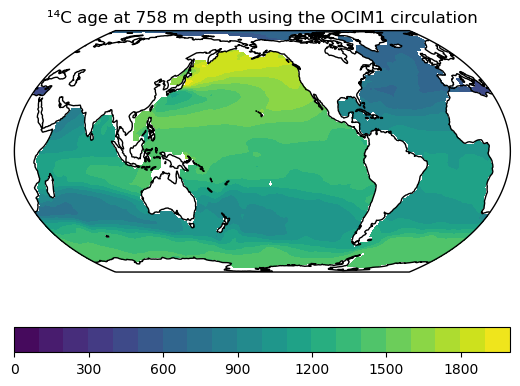

In [15]:
ENV["MPLBACKEND"]="qt5agg"
using PyPlot, PyCall
clf()
ccrs = pyimport("cartopy.crs")
ax = subplot(projection=ccrs.EqualEarth(central_longitude=-155.0))
ax.coastlines()
lon_cyc = ustrip.([grd.lon; grd.lon[1] + 360u"°"]) # making it cyclic for Cartopy
age_cyc = hcat(C14age_3D_1000m_yr, C14age_3D_1000m_yr[:,1])
p = contourf(lon_cyc, ustrip.(grd.lat), age_cyc, levels=0:100:2000, transform=ccrs.PlateCarree(), zorder=-1)
colorbar(p, orientation="horizontal")
title("¹⁴C age at $(string(round(typeof(1u"m"),grd.depth[iz]))) depth using the OCIM1 circulation")
gcf() # gets the current figure to display

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*